# Sheet 5

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

In [2]:
from itertools import product
from tqdm import tqdm


# 2) Phase classification in $\phi^4$ theory

## (a)

In [3]:
train = np.load("data05/lattice_train.npy")
test = np.load("data05/lattice_test.npy")
kappa = np.arange(0.24, 0.30, 0.0025)

L = 16
lattice_shape = (L,L)

train, test = torch.tensor(train), torch.tensor(test)
symmetric_phase_data, broken_phase_data = train[0,...], train[1,...]

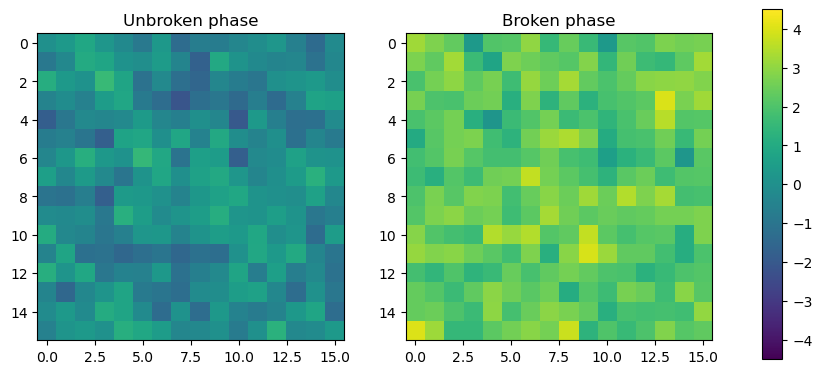

In [4]:
MIN, MAX = -4.5, 4.5
INDEX = 999
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(symmetric_phase_data[INDEX], vmin=MIN, vmax=MAX)
axes[1].imshow(broken_phase_data[INDEX], vmin=MIN, vmax=MAX)
axes[0].set_title("Unbroken phase")
axes[1].set_title("Broken phase")
# add common colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(axes[1].imshow(broken_phase_data[INDEX], vmin=MIN, vmax=MAX), cax=cbar_ax);

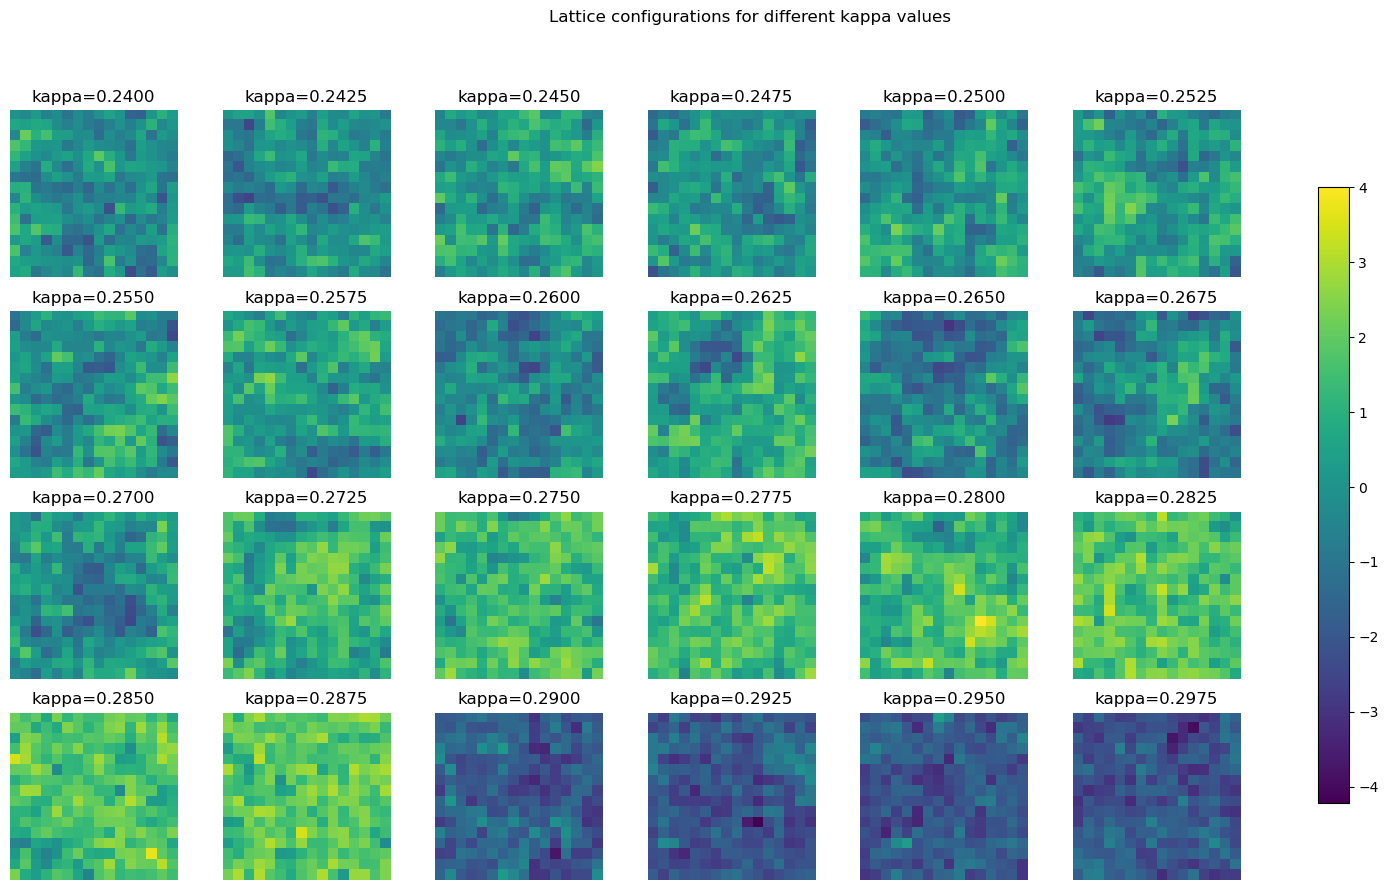

In [5]:
# TODO: Visualize lattice sides for different values of kappa
# plot 24 imshow plots in a 4x6 grid
MIN, MAX = test[:,0,...].min(), test[:,0,...].max()
fig, axes = plt.subplots(4, 6, figsize=(20,10))
for i, j in product(range(4), range(6)):
    axes[i,j].imshow(test[i*6+j, 0, ...], vmin=MIN, vmax=MAX)
    axes[i,j].set_title(f"kappa={kappa[i*6+j]:.4f}")
    axes[i,j].set_axis_off()
fig.suptitle("Lattice configurations for different kappa values")
fig.colorbar(axes[0, 0].imshow(test[0, 0, ...], vmin=MIN, vmax=MAX), ax=axes, shrink=0.8);

We see the phase transition between $\kappa = 0.2875$ and $\kappa = 0.2900$

We also try to make sure that the values are $O(1)$. The following histogram shows that the value distribution is acceptable and does not need to be pre-processed (e.g. by a log function).

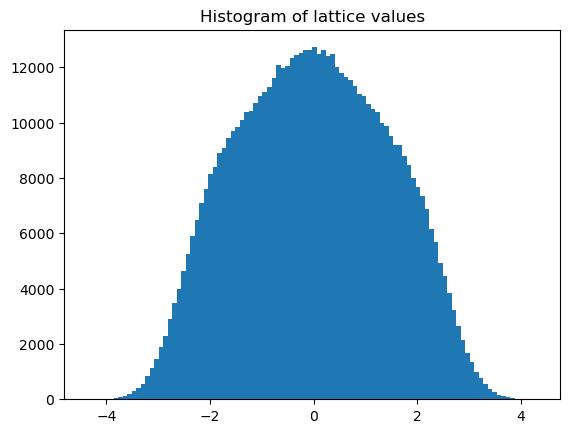

In [6]:
# Visualise the values found on the lattices
plt.hist(test.flatten(), bins=100);
plt.title("Histogram of lattice values");

## (b)

Notes from solution 4:
- do not overwrite in preprocessing, use ´.copy()´
- preprocessing using log function is useful
- standardise (subtract mean, divide by std)
- possible to put preprocessing in init function of dataset
- shuffle in dataloader 

In [7]:
# TODO: Design a CNN
class CNN(nn.Module):
    """
    Implements a CNN with 2 convolutional layers and 1 fully connected layer.
    - The first convolutional layer creates three output channels
    - The second convolutional layer also maps to three output channels
    - The fully connected layer maps to a single output
    - This is followed by a sigmoid to map to [0,1] (-> probability)

    The input is a 16x16 grid of real numbers.
    """
    def __init__(self):
        super(CNN, self).__init__()
        image_dim = 16 * 16
        # - stride is the number of pixels the kernel moves each step
        #   in practice this is the same as pooling
        # - in/out channels are the number of channels in the input/output
        #   an output channel is an 'image' produced by convolution
        #   we can produce several output channels by using several kernels (which need to be learned)
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * image_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)
        

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [9]:
model = CNN().to(device)
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

CNN(
  (main): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=768, out_features=1, bias=True)
    (6): Sigmoid()
  )
)
Model has 883 trainable parameters


## (c)

In [10]:
class phase_dataset(torch.utils.data.Dataset):
    # dont forget preprocessing:
    # convolutional layers expect input of shape (batch_size, channels, height, width)
    # we have (batch_size, height, width) -> add channel dimension
    # use .unsqueeze(1) to add channel dimension

    def __init__(self, data, labels):
        # add channel dimension
        self.data = data.unsqueeze(1)

        self.labels = labels
        self.length = len(data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [11]:
symmetric_phase_data.unsqueeze(0).shape


torch.Size([1, 1000, 16, 16])

Decide on convention: Give output as probability of being in the broken phase.

In [12]:
trn_dataset = phase_dataset(
    torch.cat([symmetric_phase_data, broken_phase_data]),
    torch.cat([torch.zeros(len(symmetric_phase_data)), torch.ones(len(broken_phase_data))])
)
trn_dataloader = torch.utils.data.DataLoader(trn_dataset, batch_size=64, shuffle=True)

In [13]:
def batch_loss(model, x, y, loss_fn):
    x, y = x.to(device), y.to(device)
    pred = model(x)
    return loss_fn(pred.flatten(), y)

In [14]:
def train_epoch(model, dataloader, losses, batch_loss_fn, loss_fn, optimizer):
    # run for each epoch (and ran over all data)
    for x, y in dataloader:
        # loading in batches of batchsize
        optimizer.zero_grad()
        loss = batch_loss_fn(model, x, y, loss_fn)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [15]:
model = CNN().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses = []
for epoch in tqdm(range(100)):
    train_losses = train_epoch(model, trn_dataloader, train_losses, batch_loss, loss_fn, optimizer)


100%|██████████| 100/100 [00:08<00:00, 11.79it/s]


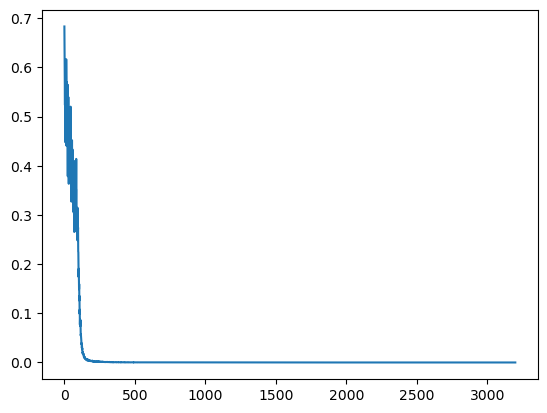

In [16]:
plt.plot(train_losses)

## (d)

In [17]:
# TODO: Evaluate CNN
outputs = []
for k in range(24):
    x = test[k, ...].unsqueeze(1).to(device)
    outputs.append(model(x).flatten())
outputs = torch.stack(outputs)

In [18]:
means = outputs.mean(dim=1)
stds = outputs.std(dim=1)

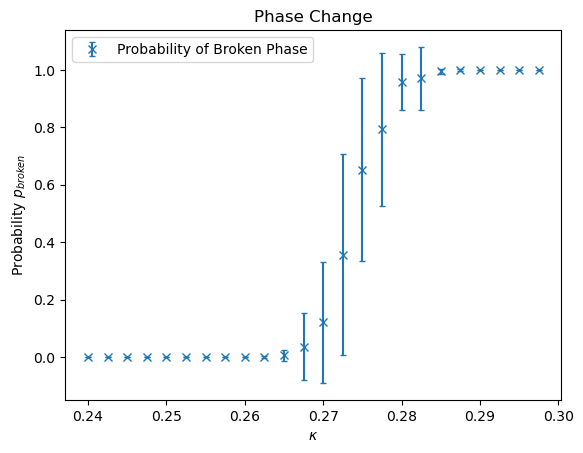

In [19]:
plt.errorbar(
    kappa,
    outputs.mean(dim=1).detach().cpu().numpy(),
    yerr=outputs.std(dim=1).detach().cpu().numpy(),
    capsize=2,
    label="Probability of Broken Phase",
    fmt="x"
)
plt.xlabel("$\kappa$")
plt.ylabel("Probability $p_{broken}$")
plt.title("Phase Change")
plt.legend();

We still need to determine the location of the $p_{broken}$-intercept

# 3) Uncertainties in Amplitude Regression

In [3]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
# import os, sys
# import wget
# from zipfile import ZipFile
# from tqdm import tqdm

# DESTINATION = "data04"
# url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
# filename = "tutorial-2-data.zip"
# url = url + filename

# os.makedirs(DESTINATION, exist_ok=True)
# os.chdir(DESTINATION)
# wget.download(url, filename)
# with ZipFile(filename, "r") as zip_ref:
#     for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
#         zip_ref.extract(member=file)
# %ls
# os.chdir("..")

In [4]:
# load data
trn_dat = np.load("data04/tutorial-2-data/trn_dat.npy")
trn_amp = np.load("data04/tutorial-2-data/trn_amp.npy")

val_dat = np.load("data04/tutorial-2-data/val_dat.npy")
val_amp = np.load("data04/tutorial-2-data/val_amp.npy")

tst_dat = np.load("data04/tutorial-2-data/tst_dat.npy")
tst_amp = np.load("data04/tutorial-2-data/tst_amp.npy")

print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


(a) 

In [9]:
nev = trn_dat.shape[0]
trn_datf = np.reshape(trn_dat, (nev, -1))
val_datf = np.reshape(val_dat, (nev, -1))
tst_datf = np.reshape(tst_dat, (nev, -1))

In [10]:
def preprocess_x(x_in, mean=None, std=None):
    x = x_in.copy() # do not overwrite
    if mean is None or std is None:
        mean = x.mean(keepdims=True)
        std = x.std(keepdims=True)
    x = (x - mean) / std # standardize
    assert np.isfinite(x).all() # check for nans and infs
    return torch.Tensor(x).float(), mean, std # create torch tensors
    
def preprocess_A(A_in, mean=None, std=None):
    A = A_in.copy()
    A = np.log(A)
    if mean is None or std is None:
        mean = A.mean(keepdims=True)
        std = A.std(keepdims=True)
    A = (A - mean) / std
    assert np.isfinite(A).all() 
    return torch.tensor(A).float().unsqueeze(-1), mean, std

def undo_preprocess_A(A_in, mean, std):
    A = A_in.copy()
    A = A * std + mean
    A = np.exp(A)
    return A

In [11]:
class amp_dataset(torch.utils.data.Dataset):
    
    def __init__(self, data, amp):
        self.data = data
        self.amp = amp

    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx], self.amp[idx]

In [111]:
# TODO: Recycle code from last sheet
# create datasets and dataloaders
trn_datfp, mean_x, std_x = preprocess_x(trn_datf)
val_datfp, _, _ = preprocess_x(val_datf, mean_x, std_x)
tst_datfp, _, _ = preprocess_x(tst_datf, mean_x, std_x)

trn_ampp, mean_A, std_A = preprocess_A(trn_amp)
val_ampp, _, _ = preprocess_A(val_amp, mean_A, std_A)
tst_ampp, _, _ = preprocess_A(tst_amp, mean_A, std_A)

trn_dataset = amp_dataset(trn_datfp, trn_ampp)
val_dataset = amp_dataset(val_datfp, val_ampp)
tst_dataset = amp_dataset(tst_datfp, tst_ampp)

batch_size = 64
trn_dataloader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
tst_dataloader = torch.utils.data.DataLoader(tst_dataset, batch_size=batch_size, shuffle=False)

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [15]:
class amp_net(nn.Module):
    
    def __init__(self, hdn_dim=32, ipt_dim=20, opt_dim=1, n_layers=2):
        super(amp_net, self).__init__()
        
        assert n_layers>=2
        
        layers = []
        layers.append(nn.Linear(ipt_dim, hdn_dim))
        layers.append(nn.ReLU())
        for _ in range(n_layers-2):
            layers.append(nn.Linear(hdn_dim, hdn_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hdn_dim, opt_dim))
        
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

In [19]:

def train_epoch(model, dataloader, losses, loss_fn):
    for x, y in dataloader:
        optimizer.zero_grad()
        
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [94]:
# TODO: Train ensemble of deterministic networks
# common to all models: design, loss function, N_EPOCHS, all_train_losses
# different for each model: model, optimizer, train_losses

N_MODELS = 10
N_EPOCHS = 10
models = [amp_net(hdn_dim=32, n_layers=4).to(device) for _ in range(N_MODELS)]
loss_fn = nn.MSELoss()
all_train_losses = []

for mnum, m in enumerate(models):
    print(f"Training Model {mnum+1} of {N_EPOCHS}.")
    optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)
    train_losses = []
    for epoch in tqdm(range(N_EPOCHS)):
        train_losses = train_epoch(m, trn_dataloader, train_losses, loss_fn)
    all_train_losses.append(train_losses)

Training Model 1 of 10.


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Training Model 2 of 10.


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


Training Model 3 of 10.


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Training Model 4 of 10.


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Training Model 5 of 10.


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Training Model 6 of 10.


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Training Model 7 of 10.


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Training Model 8 of 10.


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Training Model 9 of 10.


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Training Model 10 of 10.


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


In [95]:
all_train_losses = np.array(all_train_losses)

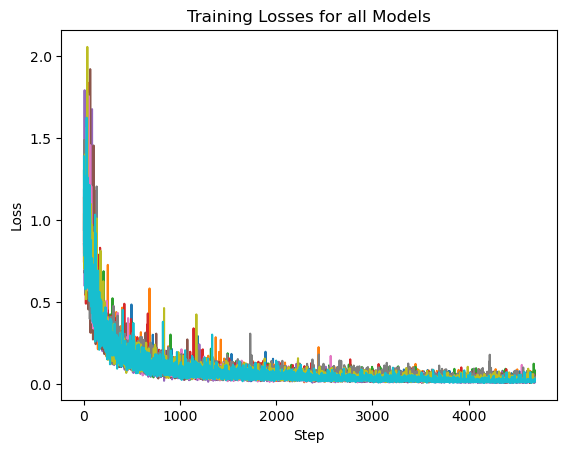

In [96]:
for loss in all_train_losses:
    plt.plot(loss)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Losses for all Models");

In [97]:
# TODO: Evaluate ensemble -> List of predictions for log A
# result: array preds of shape (10, 30000)
all_predictions = torch.stack([m(tst_datfp).flatten() for m in models], dim=0)
all_predictions.shape

torch.Size([10, 30000])

In [98]:
logA_std = tst_ampp.std().detach().cpu().numpy()
print(f"The standard deviation of log A_tst is {logA_std:.4f}")

The standard deviation of log A_tst is 0.9912


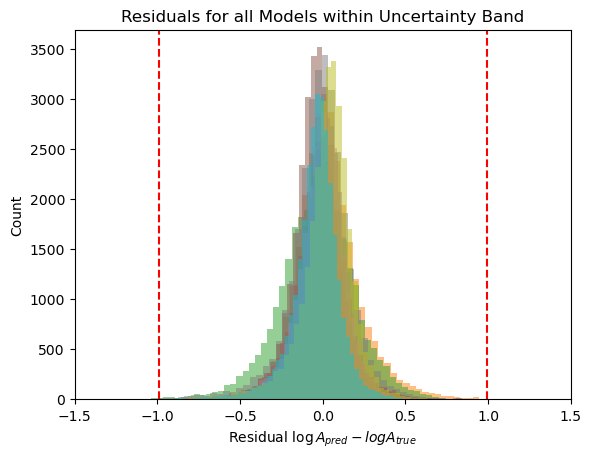

In [99]:
for mnum, m in enumerate(models):
    plt.hist(
        (m(tst_datfp) - tst_ampp).detach().cpu().numpy(),
        bins=100,
        alpha=0.5,
    );
plt.xlim(-1.5, 1.5)
plt.axvline(logA_std, linestyle="--", color="red")
plt.axvline(-logA_std, linestyle="--", color="red")
plt.xlabel("Residual $\log A_{pred} - log A_{true}$")
plt.ylabel("Count")
plt.title("Residuals for all Models within Uncertainty Band");

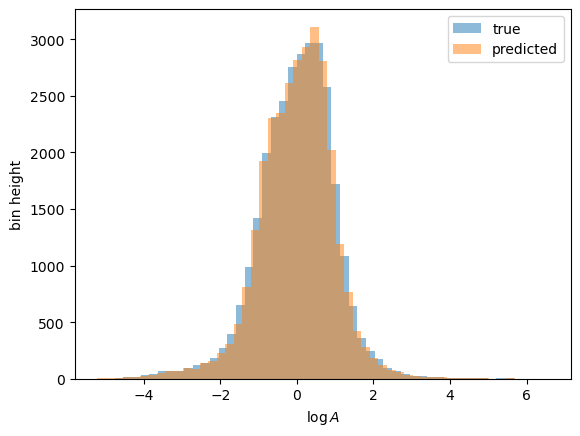

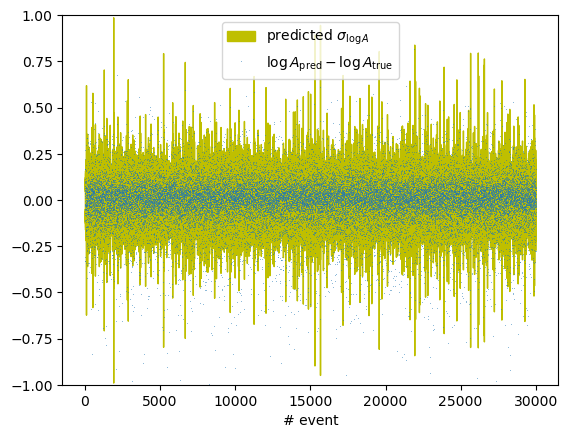

In [117]:
preds = all_predictions.detach().cpu().numpy()

# uncertainties at event level

preds_means = np.mean(preds, axis=0)
preds_stds = np.std(preds, axis=0)

plt.hist(tst_ampp.detach().numpy().flatten(), bins=50, alpha=.5, label="true")
plt.hist(preds_means, bins=50, alpha=.5, label="predicted")
plt.legend()
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.show()

x = range(len(tst_amp))
plt.fill_between(x, preds_stds, -preds_stds, color="y", label=r"predicted $\sigma_{\log A}$")
plt.plot(x, preds_means - tst_ampp.detach().numpy().flatten(), ",", alpha=.5, ms=.1, label=r"$\log A_\mathrm{pred}-\log A_\mathrm{true}$")
plt.xlabel("# event")
plt.ylim(-1,1)
plt.legend()
plt.show()


This means that the predictions agree to the true value within the error bounds we determined.

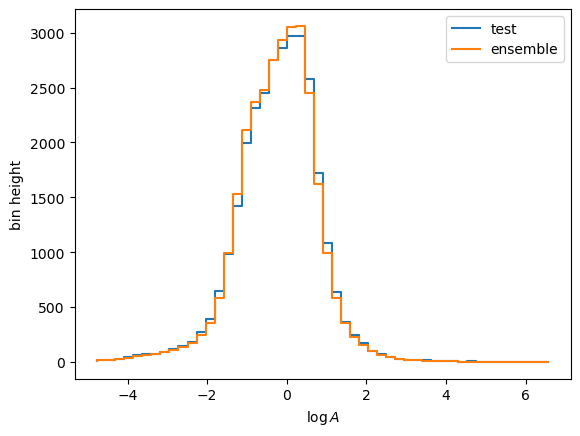

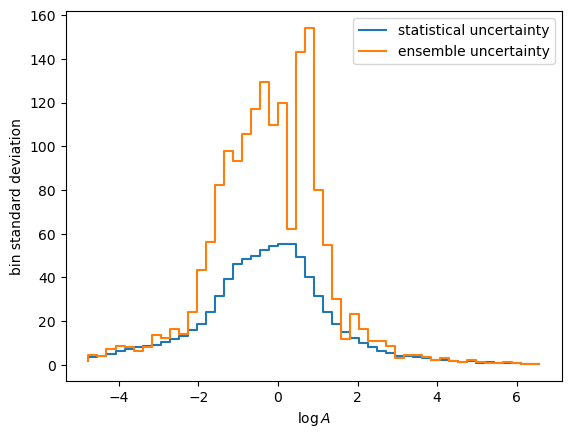

/tmp/ipykernel_119488/2232668583.py:38: RuntimeWarning: invalid value encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])
/tmp/ipykernel_119488/2232668583.py:39: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt( (y_err/y)**2 + (hist_errors[0] / hists[0])**2)
/tmp/ipykernel_119488/2232668583.py:38: RuntimeWarning: divide by zero encountered in divide
  ratio = (y * scale) / (hists[0] * scales[0])


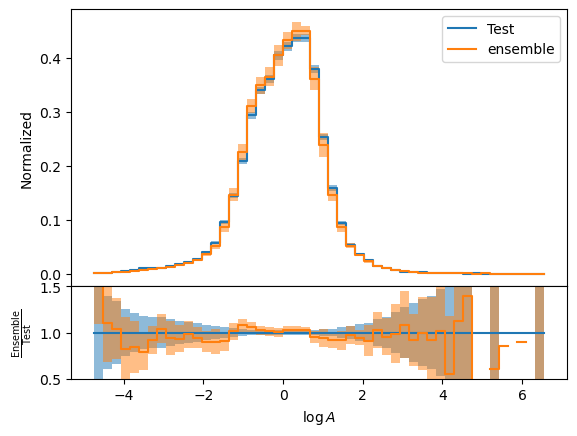

In [120]:
# uncertainties at histogram level

hist_test, bins = np.histogram(tst_ampp.detach().numpy(), bins=50)
hist_data = np.array([np.histogram(preds[i,:], bins=bins)[0] for i in range(N_MODELS)])
hist_means = np.mean(hist_data, axis=0)
hist_stds = np.std(hist_data, axis=0)

# means
dup_last = lambda a: np.append(a, a[-1])
plt.step(bins, dup_last(hist_test), label="test")
plt.step(bins, dup_last(hist_means), label="ensemble")
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.legend()
plt.show()

# standard deviations
plt.step(bins, dup_last(np.sqrt(hist_means)), label="statistical uncertainty")
plt.step(bins, dup_last(hist_stds), label="ensemble uncertainty")
plt.xlabel(r"$\log A$")
plt.ylabel("bin standard deviation")
plt.legend()
plt.show()

# means + standard deviations
hists = [hist_test, hist_means]
hist_errors = [np.sqrt(hist_test), hist_stds]
# this is just a simple numeric integration of the area under the curve
integrals = [np.sum((bins[1:] - bins[:-1])*y) for y in hists]
# we want to scale the area to 1 after all
scales = [1 / integral if integral != 0. else 1. for integral in integrals]

label = ["Test", "ensemble"]
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1], "hspace": 0.})
for y, y_err, scale, label in zip(hists, hist_errors, scales, label):
    axs[0].step(bins, dup_last(y) * scale, label=label, where="post")
    axs[0].fill_between(bins, dup_last(y + y_err) * scale, 
                     dup_last(y - y_err) * scale, alpha=.5, step="post")
    
    ratio = (y * scale) / (hists[0] * scales[0])
    ratio_err = np.sqrt( (y_err/y)**2 + (hist_errors[0] / hists[0])**2)
    ratio[np.isnan(ratio)] = 1.
    ratio_err[np.isnan(ratio)] = 0.
    
    axs[1].step(bins, dup_last(ratio), where="post")
    axs[1].fill_between(bins, dup_last(ratio + ratio_err), dup_last(ratio - ratio_err), step="post", alpha=.5)
axs[1].set_xlabel(r"$\log A$")
axs[0].set_ylabel("Normalized")
axs[1].set_ylabel(r"$\frac{\mathrm{Ensemble}}{\mathrm{Test}}$")
axs[1].set_ylim(.5, 1.5)
axs[0].legend()
plt.show();

# TODO: Interpret results

We see that the ensemble result is comparable to the result of the true value in both value and error (provided that we ignore the head and tail).

(d)

In [ ]:
# TODO: Fill in expression for KL divergence
import math

class VBLinear(nn.Module):
    # VB = variational bayes
    def __init__(self, in_features, out_features, prior_prec=1.0, _map=False, std_init=-5):
        super(VBLinear, self).__init__()
        self.n_in = in_features
        self.n_out = out_features
        self.map = _map
        self.prior_prec = prior_prec # = 1/sigma_prior**2
        self.random = None
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.mu_w = nn.Parameter(torch.Tensor(out_features, in_features))
        self.logsig2_w = nn.Parameter(torch.Tensor(out_features, in_features)) # log(sigma_network**2)
        self.std_init = std_init
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(self.std_init, 0.001)
        self.bias.data.zero_()

    def KL(self):
        logsig2_w = self.logsig2_w.clamp(-11, 11)
        kl = None # KL divergence of variational bayes linear layer 
        return kl

    def forward(self, input):
        if self.training:
            # local reparameterization trick is more efficient and leads to
            # an estimate of the gradient with smaller variance.
            # https://arxiv.org/pdf/1506.02557.pdf
            mu_out = nn.functional.linear(input, self.mu_w, self.bias)
            logsig2_w = self.logsig2_w.clamp(-11, 11)
            s2_w = logsig2_w.exp()
            var_out = nn.functional.linear(input.pow(2), s2_w) + 1e-8
            return mu_out + var_out.sqrt() * torch.randn_like(mu_out)

        else:
            if self.map: # just return the mean, no sampling
                return nn.functional.linear(input, self.mu_w, self.bias)

            logsig2_w = self.logsig2_w.clamp(-11, 11)
            if self.random is None:
                self.random = torch.randn_like(self.logsig2_w)
            s2_w = logsig2_w.exp()
            weight = self.mu_w + s2_w.sqrt() * self.random
            return nn.functional.linear(input, weight, self.bias) + 1e-8

In [ ]:
# TODO: Create BNN (like deterministic network, but with bayesian layers)

class bayesian_amp_net(nn.Module):
    
    def __init__(self, training_size, ipt_dim=20, opt_dim=1, hdn_dim=32, n_layers=2):
        pass

    def forward(self, x):
        pass
    
    def KL(self):
        kl = 0
        for layer in self.bayesian_layers:
            kl += layer.KL()
        return kl
    
    def reset_BNN(self):
        for layer in self.bayesian_layers:
            layer.random = None

In [ ]:
def batch_loss_bayesian(model, x, y):
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)
    kl = model.KL() / trn_dat.shape[0] # correct normalization!
    loss += kl
    return loss

In [ ]:
# TODO: Train BNN

(e)

In [ ]:
# TODO: Evaluate BNN

In [ ]:
# uncertainties at event level

preds_means = np.mean(np.log(preds), axis=0)
preds_stds = np.std(np.log(preds), axis=0)

plt.hist(np.log(tst_amp), range=(-20, -8), bins=50, alpha=.5)
plt.hist(preds_means, range=(-20, -8), bins=50, alpha=.5)
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.show()

x = range(len(tst_amp))
plt.fill_between(x, preds_stds, -preds_stds, color="y", label=r"predicted $\sigma_{\log A}$")
plt.plot(x, preds_means - np.log(tst_amp), ",", alpha=.5, ms=.1, label=r"$\log A_\mathrm{pred}-\log A_\mathrm{true}$")
plt.xlabel("# event")
plt.ylim(-1,1)
plt.legend()
plt.show()

# TODO: Interpret results

In [ ]:
# uncertainties at histogram level

hist_test, bins = np.histogram(np.log(tst_amp), range=(-20,-8), bins=50)
hist_data = np.array([np.histogram(np.log(preds[i,:]), bins=bins)[0] for i in range(n_models)])
hist_means = np.mean(hist_data, axis=0)
hist_stds = np.std(hist_data, axis=0)

# means
dup_last = lambda a: np.append(a, a[-1])
plt.step(bins, dup_last(hist_test), label="test")
plt.step(bins, dup_last(hist_means), label="ensemble")
plt.xlabel(r"$\log A$")
plt.ylabel("bin height")
plt.legend()
plt.show()

# standard deviations
plt.step(bins, dup_last(np.sqrt(hist_means)), label="statistical uncertainty")
plt.step(bins, dup_last(hist_stds), label="ensemble uncertainty")
plt.xlabel(r"$\log A$")
plt.ylabel("bin standard deviation")
plt.legend()
plt.show()

# means + standard deviations
hists = [hist_test, hist_means]
hist_errors = [np.sqrt(hist_test), hist_stds]
integrals = [np.sum((bins[1:] - bins[:-1])*y) for y in hists]
scales = [1 / integral if integral != 0. else 1. for integral in integrals]

label = ["Test", "ensemble"]
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [3, 1], "hspace": 0.})
for y, y_err, scale, label in zip(hists, hist_errors, scales, label):
    axs[0].step(bins, dup_last(y) * scale, label=label, where="post")
    axs[0].fill_between(bins, dup_last(y + y_err) * scale, 
                     dup_last(y - y_err) * scale, alpha=.5, step="post")
    
    ratio = (y * scale) / (hists[0] * scales[0])
    ratio_err = np.sqrt( (y_err/y)**2 + (hist_errors[0] / hists[0])**2)
    ratio[np.isnan(ratio)] = 1.
    ratio_err[np.isnan(ratio)] = 0.
    
    axs[1].step(bins, dup_last(ratio), where="post")
    axs[1].fill_between(bins, dup_last(ratio + ratio_err), dup_last(ratio - ratio_err), step="post", alpha=.5)
axs[1].set_xlabel(r"$\log A$")
axs[0].set_ylabel("Normalized")
axs[1].set_ylabel(r"$\frac{\mathrm{Ensemble}}{\mathrm{Test}}$")
axs[1].set_ylim(.5, 1.5)
axs[0].legend()
plt.show()

# TODO: Interpret results